In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible


In [2]:
pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Data cleaning and EDA

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df_train = pd.read_csv('/content/drive/MyDrive/MIS6-Sem6/drugsCom/drugsComTest_raw.tsv',sep=None)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   53766 non-null  int64  
 1   drugName     53766 non-null  object 
 2   condition    53471 non-null  object 
 3   review       53766 non-null  object 
 4   rating       53766 non-null  float64
 5   date         53766 non-null  object 
 6   usefulCount  53766 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 2.9+ MB


In [7]:
df_train.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4


In [8]:
del df_train['Unnamed: 0']
del df_train['date']

In [9]:
print("number of drugs:", len(df_train['drugName'].unique()))
print("number of conditions:", len(df_train['condition'].unique()))

number of drugs: 2637
number of conditions: 709


In [10]:
drug_per_condition = df_train.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
drug_per_condition

condition
Pain                        163
Birth Control               155
Not Listed / Othe           111
High Blood Pressure          99
Depression                   97
                           ... 
Cyclitis                      1
Intraabdominal Infection      1
Renal Tubular Acidosis        1
Allergic Urticaria            1
Pain/Feve                     1
Name: drugName, Length: 708, dtype: int64

In [11]:
drug_per_condition[:30]

condition
Pain                         163
Birth Control                155
Not Listed / Othe            111
High Blood Pressure           99
Depression                    97
Acne                          90
Diabetes, Type 2              77
Anxiety                       70
Bipolar Disorde               66
Insomnia                      66
Allergic Rhinitis             65
Rheumatoid Arthritis          64
Osteoarthritis                57
Abnormal Uterine Bleeding     50
Migraine                      49
ADHD                          48
Major Depressive Disorde      43
ibromyalgia                   41
Endometriosis                 39
Chronic Pain                  38
Irritable Bowel Syndrome      38
Asthma, Maintenance           37
Psoriasis                     37
Migraine Prevention           36
Obesity                       36
Postmenopausal Symptoms       35
Panic Disorde                 34
Urinary Tract Infection       33
Constipation                  33
Bacterial Infection           33


In [12]:
#replace wrong name in condition column with NaN
df_train.loc[df_train['condition'].str.contains('</span>',case=False, na=False), 'condition'] = 'NAN'
df_train['condition'].replace('NAN', np.NaN, inplace=True)
df_train['condition'].replace('Not Listed / Othe', np.NaN, inplace=True)

In [13]:
#create a dictionary with drugname:condition to fill NaN
dictionary=df_train.set_index('drugName')['condition'].to_dict()
len(dictionary)

2637

In [14]:
#fill NaN value with correct condition names using created dictionary
df_train.condition.fillna(df_train.drugName.map(dictionary), inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   drugName     53766 non-null  object 
 1   condition    53729 non-null  object 
 2   review       53766 non-null  object 
 3   rating       53766 non-null  float64
 4   usefulCount  53766 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 2.1+ MB


In [15]:
#drop rows with still missing values in condition (100 rows = 0.0006% of total data)
df_train.dropna(inplace=True)

In [16]:
drug_per_condition = df_train.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
drug_per_condition

condition
Pain                                            163
Birth Control                                   155
High Blood Pressure                              99
Depression                                       97
Acne                                             90
                                               ... 
Reversal of Nondepolarizing Muscle Relaxants      1
Lyme Disease, Erythema Chronicum Migrans          1
Dumping Syndrome                                  1
Salmonella Gastroenteritis                        1
Head and Neck Cance                               1
Name: drugName, Length: 663, dtype: int64

In [17]:
drug_per_condition[:30]

condition
Pain                         163
Birth Control                155
High Blood Pressure           99
Depression                    97
Acne                          90
Diabetes, Type 2              77
Anxiety                       70
Insomnia                      66
Bipolar Disorde               66
Allergic Rhinitis             65
Rheumatoid Arthritis          64
Osteoarthritis                57
Abnormal Uterine Bleeding     50
Migraine                      49
ADHD                          48
Major Depressive Disorde      43
ibromyalgia                   41
Endometriosis                 39
Irritable Bowel Syndrome      38
Chronic Pain                  38
Psoriasis                     37
Asthma, Maintenance           37
Migraine Prevention           36
Obesity                       36
Postmenopausal Symptoms       35
Panic Disorde                 34
Bacterial Infection           33
Constipation                  33
Urinary Tract Infection       33
Schizophrenia                 32


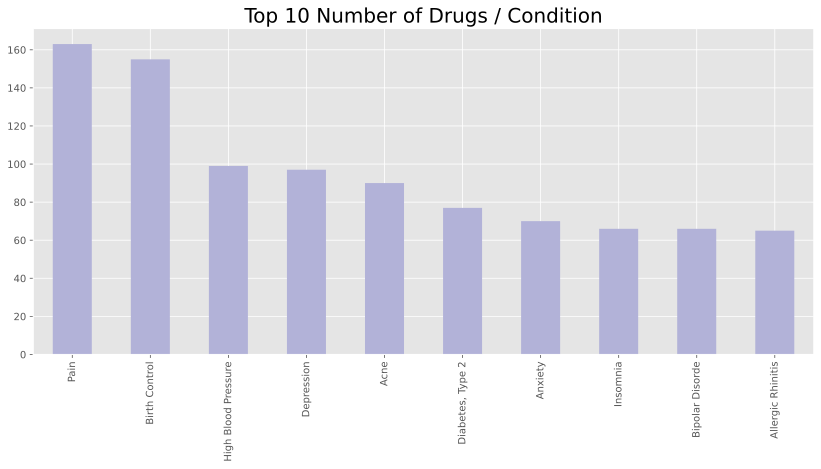

In [18]:
drug_per_condition[:10].plot(kind="bar", figsize = (14,6), fontsize = 10, color="#B2B2D8")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top 10 Number of Drugs / Condition", fontsize = 20)
plt.savefig('top10_condition.svg')

In [19]:
#selecte conditions with less than 11 drugs
condition_1=drug_per_condition[drug_per_condition<=10].keys()
condition_1

Index(['Iron Deficiency Anemia', 'Emergency Contraception',
       'Postherpetic Neuralgia', 'Tourette's Syndrome',
       'Onychomycosis, Toenail', 'Seizure Prevention', 'Underactive Thyroid',
       'Dry Skin', 'Opiate Withdrawal', 'Conjunctivitis, Bacterial',
       ...
       'Radionuclide Myocardial Perfusion Study', 'Rat-bite Feve',
       'Blepharitis', 'Renal Tubular Acidosis',
       'Dissociative Identity Disorde',
       'Reversal of Nondepolarizing Muscle Relaxants',
       'Lyme Disease, Erythema Chronicum Migrans', 'Dumping Syndrome',
       'Salmonella Gastroenteritis', 'Head and Neck Cance'],
      dtype='object', name='condition', length=539)

In [20]:
#delete condition with less than 11 drugs
df_train1=df_train[~df_train['condition'].isin(condition_1)]
df_train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46307 entries, 0 to 53765
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   drugName     46307 non-null  object 
 1   condition    46307 non-null  object 
 2   review       46307 non-null  object 
 3   rating       46307 non-null  float64
 4   usefulCount  46307 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 2.1+ MB


In [21]:
import re # Regular expression library
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [22]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
import spacy
nlp = spacy.load("en_core_web_sm")

In [23]:
#remove words needs for sentiment analysis from stopwords
n = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in n:
    stop.remove(i)

In [24]:
#add more words to stopwords
a = ['mg', 'week', 'month', 'day', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 
     'august', 'september','october','november','december', 'iv','oral','pound', 'lb', 'month', 'day','night']
for j in a:
    stop.add(j)

In [25]:
# Text preprocessing steps - remove numbers, captial letters and punctuation
alphanumeric=lambda x: re.sub('[^a-zA-Z]', ' ', x)
punc_lower=lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
split=lambda x: x.split()

df_train1['review'] = df_train1.review.map(alphanumeric).map(punc_lower).map(split)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
df_train1

,drugName,condition,review,rating,usefulCount
0,Mirtazapine,Depression,"[i, ve, tried, a, few, antidepressants, over, ...",10.0,22
1,Mesalamine,"Crohn's Disease, Maintenance","[my, son, has, crohn, s, disease, and, has, do...",8.0,17
2,Bactrim,Urinary Tract Infection,"[quick, reduction, of, symptoms]",9.0,3
3,Contrave,Weight Loss,"[contrave, combines, drugs, that, were, used, ...",9.0,35
4,Cyclafem 1 / 35,Birth Control,"[i, have, been, on, this, birth, control, for,...",9.0,4
...,...,...,...,...,...
53760,Apri,Birth Control,"[i, started, taking, apri, about, months, ago,...",9.0,18
53762,Escitalopram,Anxiety,"[i, ve, been, taking, lexapro, escitaploprgram...",9.0,11
53763,Levonorgestrel,Birth Control,"[i, m, married, years, old, and, i, have, no, ...",8.0,7
53764,Tapentadol,Pain,"[i, was, prescribed, nucynta, for, severe, nec...",1.0,20


In [27]:
#remove stopwords
df_train1['review_clean']=df_train1['review'].apply(lambda x: [item for item in x if item not in stop])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
#lemmatizing
df_train1['review_lemm']=df_train1['review_clean'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
del df_train1['review']
del df_train1['review_clean']

In [30]:
df_train1['review']=df_train1['review_lemm'].apply(lambda x:' '.join(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
del df_train1['review_lemm']
df_train1

,drugName,condition,rating,usefulCount,review
0,Mirtazapine,Depression,10.0,22,tried antidepressant year citalopram fluoxetin...
1,Mesalamine,"Crohn's Disease, Maintenance",8.0,17,son crohn disease done well asacol no complain...
2,Bactrim,Urinary Tract Infection,9.0,3,quick reduction symptom
3,Contrave,Weight Loss,9.0,35,contrave combine drug used alcohol smoking opi...
4,Cyclafem 1 / 35,Birth Control,9.0,4,birth control one cycle reading review type si...
...,...,...,...,...,...
53760,Apri,Birth Control,9.0,18,started taking apri month ago breats got notic...
53762,Escitalopram,Anxiety,9.0,11,taking lexapro escitaploprgram since first lik...
53763,Levonorgestrel,Birth Control,8.0,7,married year old no kid taking pill hassle dec...
53764,Tapentadol,Pain,1.0,20,prescribed nucynta severe neck shoulder pain t...


In [32]:
#save cleaned dataframe to csv file for later use
export_csv = df_train1.to_csv(r'df_train.csv', index = None, header=True)

In [33]:
# follow the same cleaning steps for test data
df_test = pd.read_csv('/content/drive/MyDrive/MIS6-Sem6/drugsCom/drugsComTest_raw.tsv',sep=None)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [34]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   53766 non-null  int64  
 1   drugName     53766 non-null  object 
 2   condition    53471 non-null  object 
 3   review       53766 non-null  object 
 4   rating       53766 non-null  float64
 5   date         53766 non-null  object 
 6   usefulCount  53766 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 2.9+ MB


In [35]:
del df_test['Unnamed: 0']
del df_test['date']

In [36]:
print("number of drugs:", len(df_test['drugName'].unique()))
print("number of conditions:", len(df_test['condition'].unique()))

number of drugs: 2637
number of conditions: 709


In [37]:
#delete condition with less than 11 drugs
df_test1=df_test[~df_test['condition'].isin(condition_1)]
df_test1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46427 entries, 0 to 53765
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   drugName     46427 non-null  object 
 1   condition    46132 non-null  object 
 2   review       46427 non-null  object 
 3   rating       46427 non-null  float64
 4   usefulCount  46427 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 2.1+ MB


In [38]:
df_test1.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [39]:
# Text preprocessing steps - remove numbers, captial letters and punctuation
alphanumeric=lambda x: re.sub('[^a-zA-Z]', ' ', x)
punc_lower=lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
split=lambda x: x.split()

df_test1['review'] = df_test1.review.map(alphanumeric).map(punc_lower).map(split)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
#remove stopwords
df_test1['review_clean']=df_test1['review'].apply(lambda x: [item for item in x if item not in stop])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
#lemmatizing
df_test1['review_lemm']=df_test1['review_clean'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [43]:
del df_test1['review']
del df_test1['review_clean']

In [44]:
df_test1['review']=df_test1['review_lemm'].apply(lambda x:' '.join(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
del df_test1['review_lemm']
df_test1

,drugName,condition,rating,usefulCount,review
0,Mirtazapine,Depression,10.0,22,"[tried, antidepressant, year, citalopram, fluo..."
1,Mesalamine,"Crohn's Disease, Maintenance",8.0,17,"[son, crohn, disease, done, well, asacol, no, ..."
2,Bactrim,Urinary Tract Infection,9.0,3,"[quick, reduction, symptom]"
3,Contrave,Weight Loss,9.0,35,"[contrave, combine, drug, used, alcohol, smoki..."
4,Cyclafem 1 / 35,Birth Control,9.0,4,"[birth, control, one, cycle, reading, review, ..."
...,...,...,...,...,...
53760,Apri,Birth Control,9.0,18,"[started, taking, apri, month, ago, breats, go..."
53762,Escitalopram,Anxiety,9.0,11,"[taking, lexapro, escitaploprgram, since, firs..."
53763,Levonorgestrel,Birth Control,8.0,7,"[married, year, old, no, kid, taking, pill, ha..."
53764,Tapentadol,Pain,1.0,20,"[prescribed, nucynta, severe, neck, shoulder, ..."


In [47]:
#save cleaned test data to csv file for later use
export_csv = df_test1.to_csv(r'df_test.csv', index = None, header=True)